This is my try with NSL-KDD dataset, which is an improved version of well-known KDD'99 dataset. 

In [28]:
# Here are some imports that are used along this notebook
import math
import itertools
import pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from collections import OrderedDict
%matplotlib inline
gt0 = time()

# Spark and SparkSQL related imports
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import udf, split, col, lit
import pyspark.sql.functions as sql

# Spark ML related imports
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, IndexToString, OneHotEncoder, \
                               StandardScaler, VectorAssembler, VectorIndexer, PCA
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [31]:
parallelizationLevel = 4
# Setting seed for reproducibility
seed = 1928374650123456789
spark_conf = SparkConf().setAll([
    ('spark.executor.memory', '1g'),
    ('spark.driver.memory', '1g')
])

spark = SparkSession \
    .builder \
    .master('local[{0}]'.format(parallelizationLevel)) \
    .getOrCreate()
print('Spark version {0} started'.format(spark.version))

Spark version 2.4.4 started


In [3]:
import pyspark
from pyspark.sql import SQLContext, Row

# Creating local SparkContext with 8 threads and SQLContext based on it
sc = pyspark.SparkContext(master='local[8]')
sc.setLogLevel('INFO')
sqlContext = SQLContext(sc)

In [83]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf, split, col
import pyspark.sql.functions as sql

train20_nsl_kdd_dataset_path = "Network-Intrusion-Detection/KDDTrain+_20Percent.txt"
train_nsl_kdd_dataset_path = "Network-Intrusion-Detection/KDDTrain+.txt"
test_nsl_kdd_dataset_path = "Network-Intrusion-Detection/KDDTest+.txt"

col_names = np.array(["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels","labels222"])

nominal_inx = [1, 2, 3]
binary_inx = [6, 11, 13, 14, 20, 21]
numeric_inx = list(set(range(41)).difference(nominal_inx).difference(binary_inx))

nominal_cols = col_names[nominal_inx].tolist()
binary_cols = col_names[binary_inx].tolist()
numeric_cols = col_names[numeric_inx].tolist()

In [39]:
def load_dataset(path):
    dataset_rdd = sc.textFile(path, 8).map(lambda line: line.split(','))
    dataset_df = (dataset_rdd.toDF(col_names.tolist()).select(
                    col('duration').cast(DoubleType()),
                    col('protocol_type').cast(StringType()),
                    col('service').cast(StringType()),
                    col('flag').cast(StringType()),
                    col('src_bytes').cast(DoubleType()),
                    col('dst_bytes').cast(DoubleType()),
                    col('land').cast(DoubleType()),
                    col('wrong_fragment').cast(DoubleType()),
                    col('urgent').cast(DoubleType()),
                    col('hot').cast(DoubleType()),
                    col('num_failed_logins').cast(DoubleType()),
                    col('logged_in').cast(DoubleType()),
                    col('num_compromised').cast(DoubleType()),
                    col('root_shell').cast(DoubleType()),
                    col('su_attempted').cast(DoubleType()),
                    col('num_root').cast(DoubleType()),
                    col('num_file_creations').cast(DoubleType()),
                    col('num_shells').cast(DoubleType()),
                    col('num_access_files').cast(DoubleType()),
                    col('num_outbound_cmds').cast(DoubleType()),
                    col('is_host_login').cast(DoubleType()),
                    col('is_guest_login').cast(DoubleType()),
                    col('count').cast(DoubleType()),
                    col('srv_count').cast(DoubleType()),
                    col('serror_rate').cast(DoubleType()),
                    col('srv_serror_rate').cast(DoubleType()),
                    col('rerror_rate').cast(DoubleType()),
                    col('srv_rerror_rate').cast(DoubleType()),
                    col('same_srv_rate').cast(DoubleType()),
                    col('diff_srv_rate').cast(DoubleType()),
                    col('srv_diff_host_rate').cast(DoubleType()),
                    col('dst_host_count').cast(DoubleType()),
                    col('dst_host_srv_count').cast(DoubleType()),
                    col('dst_host_same_srv_rate').cast(DoubleType()),
                    col('dst_host_diff_srv_rate').cast(DoubleType()),
                    col('dst_host_same_src_port_rate').cast(DoubleType()),
                    col('dst_host_srv_diff_host_rate').cast(DoubleType()),
                    col('dst_host_serror_rate').cast(DoubleType()),
                    col('dst_host_srv_serror_rate').cast(DoubleType()),
                    col('dst_host_rerror_rate').cast(DoubleType()),
                    col('dst_host_srv_rerror_rate').cast(DoubleType()),
                    col('labels').cast(StringType()),
                    col('labels222').cast(DoubleType())))
                    

    return dataset_df

In [34]:


def load_dataset(path, dsType):
    dataset_rdd = spark.sparkContext.textFile(path, parallelizationLevel).map(lambda line: line.split(','))
    dataset_df = (dataset_rdd.toDF(col_names.tolist()).select(
                    col('duration').cast(DoubleType()),
                    col('protocol_type').cast(StringType()),
                    col('service').cast(StringType()),
                    col('flag').cast(StringType()),
                    col('src_bytes').cast(DoubleType()),
                    col('dst_bytes').cast(DoubleType()),
                    col('land').cast(DoubleType()),
                    col('wrong_fragment').cast(DoubleType()),
                    col('urgent').cast(DoubleType()),
                    col('hot').cast(DoubleType()),
                    col('num_failed_logins').cast(DoubleType()),
                    col('logged_in').cast(DoubleType()),
                    col('num_compromised').cast(DoubleType()),
                    col('root_shell').cast(DoubleType()),
                    col('su_attempted').cast(DoubleType()),
                    col('num_root').cast(DoubleType()),
                    col('num_file_creations').cast(DoubleType()),
                    col('num_shells').cast(DoubleType()),
                    col('num_access_files').cast(DoubleType()),
                    col('num_outbound_cmds').cast(DoubleType()),
                    col('is_host_login').cast(DoubleType()),
                    col('is_guest_login').cast(DoubleType()),
                    col('count').cast(DoubleType()),
                    col('srv_count').cast(DoubleType()),
                    col('serror_rate').cast(DoubleType()),
                    col('srv_serror_rate').cast(DoubleType()),
                    col('rerror_rate').cast(DoubleType()),
                    col('srv_rerror_rate').cast(DoubleType()),
                    col('same_srv_rate').cast(DoubleType()),
                    col('diff_srv_rate').cast(DoubleType()),
                    col('srv_diff_host_rate').cast(DoubleType()),
                    col('dst_host_count').cast(DoubleType()),
                    col('dst_host_srv_count').cast(DoubleType()),
                    col('dst_host_same_srv_rate').cast(DoubleType()),
                    col('dst_host_diff_srv_rate').cast(DoubleType()),
                    col('dst_host_same_src_port_rate').cast(DoubleType()),
                    col('dst_host_srv_diff_host_rate').cast(DoubleType()),
                    col('dst_host_serror_rate').cast(DoubleType()),
                    col('dst_host_srv_serror_rate').cast(DoubleType()),
                    col('dst_host_rerror_rate').cast(DoubleType()),
                    col('dst_host_srv_rerror_rate').cast(DoubleType()),
                    col('labels').cast(StringType()),
                    col('difficulty_group').cast(StringType())))

    return dataset_df \
        .withColumn('ds', lit(dsType)) \
        .withColumn('labels2', sql.regexp_replace(col('labels'), '^(?!normal).*$', 'attack')) \
        .withColumn('labels5', attack_mapping_udf(col('labels'))) \
        .cache()

In [40]:
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import StringIndexer
from pyspark import keyword_only
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param

# Dictionary that contains mapping of various attacks to the four main categories
attack_dict = {
    'normal': 'normal',
    
    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',
    
    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',
    
    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',    
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}

attack_mapping_udf = udf(lambda v: attack_dict[v])

class Labels2Converter(Transformer):

    @keyword_only
    def __init__(self):
        super(Labels2Converter, self).__init__()

    def _transform(self, dataset):
        return dataset.withColumn('labels2', sql.regexp_replace(col('labels'), '^(?!normal).*$', 'attack'))
     
class Labels5Converter(Transformer):
    
    @keyword_only
    def __init__(self):
        super(Labels5Converter, self).__init__()

    def _transform(self, dataset):
        return dataset.withColumn('labels5', attack_mapping_udf(col('labels')))
    
labels2_indexer = StringIndexer(inputCol="labels2", outputCol="labels2_index")
labels5_indexer = StringIndexer(inputCol="labels5", outputCol="labels5_index")

labels_mapping_pipeline = Pipeline(stages=[Labels2Converter(), Labels5Converter(), labels2_indexer, labels5_indexer])

labels2 = ['normal', 'attack']
labels5 = ['normal', 'DoS', 'Probe', 'R2L', 'U2R']
labels_col = 'labels2_index'

In [42]:
# Loading train data
t0 = time()
train_df = load_dataset(train_nsl_kdd_dataset_path)

# Fitting preparation pipeline
labels_mapping_model = labels_mapping_pipeline.fit(train_df)

# Transforming labels column and adding id column
train_df = labels_mapping_model.transform(train_df).withColumn('id', sql.monotonically_increasing_id())

train_df = train_df.cache()
print(train_df.count())
print(time() - t0)

125973
54.83766531944275


In [43]:
# Loading test data
t0 = time()
test_df = load_dataset(test_nsl_kdd_dataset_path)

# Transforming labels column and adding id column
test_df = labels_mapping_model.transform(test_df).withColumn('id', sql.monotonically_increasing_id())

test_df = test_df.cache()
print(test_df.count())
print(time() - t0)

22544
16.86012315750122


In [44]:
# Labels columns
(train_df.groupby('labels2').count().show())
(train_df.groupby('labels5').count().sort(sql.desc('count')).show())

+-------+-----+
|labels2|count|
+-------+-----+
| normal|67343|
| attack|58630|
+-------+-----+

+-------+-----+
|labels5|count|
+-------+-----+
| normal|67343|
|    DoS|45927|
|  Probe|11656|
|    R2L|  995|
|    U2R|   52|
+-------+-----+



In [45]:
(test_df.groupby('labels2').count().show())
(test_df.groupby('labels5').count().sort(sql.desc('count')).show())

+-------+-----+
|labels2|count|
+-------+-----+
| normal| 9711|
| attack|12833|
+-------+-----+

+-------+-----+
|labels5|count|
+-------+-----+
| normal| 9711|
|    DoS| 7458|
|    R2L| 2754|
|  Probe| 2421|
|    U2R|  200|
+-------+-----+



In [46]:
# 'protocol_type' nominal column
(train_df.crosstab(nominal_cols[0], 'labels2').sort(sql.asc(nominal_cols[0] + '_labels2')).show())
(train_df.crosstab(nominal_cols[0], 'labels5').sort(sql.asc(nominal_cols[0] + '_labels5')).show())

+---------------------+------+------+
|protocol_type_labels2|attack|normal|
+---------------------+------+------+
|                 icmp|  6982|  1309|
|                  tcp| 49089| 53600|
|                  udp|  2559| 12434|
+---------------------+------+------+

+---------------------+-----+-----+---+---+------+
|protocol_type_labels5|  DoS|Probe|R2L|U2R|normal|
+---------------------+-----+-----+---+---+------+
|                 icmp| 2847| 4135|  0|  0|  1309|
|                  tcp|42188| 5857|995| 49| 53600|
|                  udp|  892| 1664|  0|  3| 12434|
+---------------------+-----+-----+---+---+------+



In [47]:
# 'service' nominal column
print(train_df.select(nominal_cols[1]).distinct().count())
(train_df.crosstab(nominal_cols[1], 'labels2').sort(sql.asc(nominal_cols[1] + '_labels2')).show(n=70))
(train_df.crosstab(nominal_cols[1], 'labels5').sort(sql.asc(nominal_cols[1] + '_labels5')).show(n=70))

70
+---------------+------+------+
|service_labels2|attack|normal|
+---------------+------+------+
|            IRC|     1|   186|
|            X11|     6|    67|
|         Z39_50|   862|     0|
|            aol|     2|     0|
|           auth|   719|   236|
|            bgp|   710|     0|
|        courier|   734|     0|
|       csnet_ns|   545|     0|
|            ctf|   563|     0|
|        daytime|   521|     0|
|        discard|   538|     0|
|         domain|   531|    38|
|       domain_u|     9|  9034|
|           echo|   434|     0|
|          eco_i|  4089|   497|
|          ecr_i|  2887|   190|
|            efs|   485|     0|
|           exec|   474|     0|
|         finger|  1222|   545|
|            ftp|   836|   918|
|       ftp_data|  1876|  4984|
|         gopher|   518|     0|
|        harvest|     2|     0|
|      hostnames|   460|     0|
|           http|  2289| 38049|
|      http_2784|     1|     0|
|       http_443|   530|     0|
|      http_8001|     2|     0|
|    

In [48]:
# 'flag' nominal column
print(train_df.select(nominal_cols[2]).distinct().count())
(train_df.crosstab(nominal_cols[2], 'labels2').sort(sql.asc(nominal_cols[2] + '_labels2')).show())
(train_df.crosstab(nominal_cols[2], 'labels5').sort(sql.asc(nominal_cols[2] + '_labels5')).show())

11
+------------+------+------+
|flag_labels2|attack|normal|
+------------+------+------+
|         OTH|    35|    11|
|         REJ|  8540|  2693|
|        RSTO|  1343|   219|
|      RSTOS0|   103|     0|
|        RSTR|  2275|   146|
|          S0| 34497|   354|
|          S1|     4|   361|
|          S2|     8|   119|
|          S3|     4|    45|
|          SF| 11552| 63393|
|          SH|   269|     2|
+------------+------+------+

+------------+-----+-----+---+---+------+
|flag_labels5|  DoS|Probe|R2L|U2R|normal|
+------------+-----+-----+---+---+------+
|         OTH|    0|   35|  0|  0|    11|
|         REJ| 5671| 2869|  0|  0|  2693|
|        RSTO| 1216|   80| 46|  1|   219|
|      RSTOS0|    0|  103|  0|  0|     0|
|        RSTR|   90| 2180|  5|  0|   146|
|          S0|34344|  153|  0|  0|   354|
|          S1|    2|    1|  1|  0|   361|
|          S2|    5|    2|  1|  0|   119|
|          S3|    0|    1|  3|  0|    45|
|          SF| 4599| 5967|935| 51| 63393|
|          SH| 

In [49]:
# Binary columns
(train_df.select(binary_cols).describe().toPandas().transpose())

0                      1                      2    3    4
summary          count                   mean                 stddev  min  max
land            125973  1.9845522453224102E-4   0.014086071671513094  0.0  1.0
logged_in       125973     0.3957355941352512    0.48901005300524175  0.0  1.0
root_shell      125973  0.0013415573178379495    0.03660284383979861  0.0  1.0
su_attempted    125973  0.0011034110483992602    0.04515438381386557  0.0  2.0
is_host_login   125973   7.938208981289641E-6  0.0028174827384191085  0.0  1.0
is_guest_login  125973   0.009422654060790804    0.09661232709143104  0.0  1.0

In [50]:
# 'su_attempted' should be a binary feature, but has 3 values
(train_df.crosstab('su_attempted', 'labels2').show())

+--------------------+------+------+
|su_attempted_labels2|attack|normal|
+--------------------+------+------+
|                 2.0|     0|    59|
|                 1.0|     1|    20|
|                 0.0| 58629| 67264|
+--------------------+------+------+



In [51]:
# '2.0' value is replaced to '0.0' for both train and test datasets
train_df = train_df.replace(2.0, 0.0, 'su_attempted')
test_df = test_df.replace(2.0, 0.0, 'su_attempted')

In [52]:
# Numeric columns
print(len(numeric_cols))
(train_df.select(numeric_cols).describe().toPandas().transpose())

32


0                      1  \
summary                       count                   mean   
duration                     125973      287.1446500440571   
src_bytes                    125973      45566.74300048423   
dst_bytes                    125973     19779.114421344257   
wrong_fragment               125973   0.022687401268525795   
urgent                       125973  1.1113492573805498E-4   
hot                          125973    0.20440888126820828   
num_failed_logins            125973  0.0012224841831186047   
num_compromised              125973      0.279250315543807   
num_root                     125973    0.30219173949973405   
num_file_creations           125973   0.012669381534138267   
num_shells                   125973  4.1278686702706137E-4   
num_access_files             125973   0.004096115834345455   
num_outbound_cmds            125973                    0.0   
count                        125973       84.1075547934875   
srv_count                    125973     27.737888277646796   
serror_rate                  125973     0.2844845323997998   
srv_serror_rate              125973     0.2824853738499519   
rerror_rate                  125973    0.11995848316702805   
srv_rerror_rate              125973    0.12118326943075099   
same_srv_rate                125973      0.660927659101567   
diff_srv_rate                125973    0.06305263826375185   
srv_diff_host_rate           125973     0.0973216482897124   
dst_host_count               125973     182.14894461511594   
dst_host_srv_count           125973     115.65300500900987   
dst_host_same_srv_rate       125973      0.521241694648872   
dst_host_diff_srv_rate       125973    0.08295110857087822   
dst_host_same_src_port_rate  125973    0.14837885896184153   
dst_host_srv_diff_host_rate  125973    0.03254244957252654   
dst_host_serror_rate         125973     0.2844524620355186   
dst_host_srv_serror_rate     125973     0.2784845165233854   
dst_host_rerror_rate         125973    0.11883181316631297   
dst_host_srv_rerror_rate     125973    0.12023989267541413   

                                                2    3              4  
summary                                    stddev  min            max  
duration                        2604.515309867592  0.0        42908.0  
src_bytes                       5870331.181893551  0.0  1.379963888E9  
dst_bytes                      4021269.1514414474  0.0  1.309937401E9  
wrong_fragment                0.25352998595201254  0.0            3.0  
urgent                       0.014366026620154243  0.0            3.0  
hot                            2.1499684337047587  0.0           77.0  
num_failed_logins            0.045239138981329835  0.0            5.0  
num_compromised                23.942042242795125  0.0         7479.0  
num_root                         24.3996180888374  0.0         7468.0  
num_file_creations            0.48393506939604286  0.0           43.0  
num_shells                    0.02218112867869418  0.0            2.0  
num_access_files              0.09936955575066156  0.0            9.0  
num_outbound_cmds                             0.0  0.0            0.0  
count                          114.50860735418405  0.0          511.0  
srv_count                        72.6358396472384  0.0          511.0  
serror_rate                    0.4464556243310233  0.0            1.0  
srv_serror_rate               0.44702249836401703  0.0            1.0  
rerror_rate                    0.3204355207495171  0.0            1.0  
srv_rerror_rate                0.3236472280054629  0.0            1.0  
same_srv_rate                  0.4396228624074799  0.0            1.0  
diff_srv_rate                 0.18031440750857483  0.0            1.0  
srv_diff_host_rate            0.25983049812115877  0.0            1.0  
dst_host_count                  99.20621303459785  0.0          255.0  
dst_host_srv_count              110.7027407808648  0.0          255.0  
dst_host_same_srv_rate         0.4489493637176792  0.

In [53]:
(train_df.crosstab('num_outbound_cmds', 'labels2').show())

+-------------------------+------+------+
|num_outbound_cmds_labels2|attack|normal|
+-------------------------+------+------+
|                      0.0| 58630| 67343|
+-------------------------+------+------+



In [54]:
train_df = train_df.drop('num_outbound_cmds')
test_df = test_df.drop('num_outbound_cmds')
numeric_cols.remove('num_outbound_cmds')

In [ ]:
# from pyspark.mllib.stat import Statistics
# from pyspark.mllib.linalg import Vectors
# from pyspark.ml.feature import VectorAssembler

# t0 = time()
# stat_assembler = VectorAssembler(
#                 inputCols=numeric_cols,
#                 outputCol='features')

# stat_rdd = stat_assembler.transform(train_df).rdd.map(lambda row: row['features'].toArray())

# pearson_corr = Statistics.corr(stat_rdd, method='pearson')
# spearman_corr = Statistics.corr(stat_rdd, method='spearman')

# print(time() - t0)

In [ ]:
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# ax1.set_title("Pearson")
# ax2.set_title("Spearman")
# sns.heatmap(pearson_corr, ax=ax1)
# sns.heatmap(spearman_corr, ax=ax2)

In [ ]:
# inx_correlated_to_delete = [8, 15, 28, 17, 29]

# for inx in inx_correlated_to_delete:
#     train_df = train_df.drop(numeric_cols[inx])
#     test_df = test_df.drop(numeric_cols[inx])

# numeric_cols = [col for inx, col in enumerate(numeric_cols) if inx not in inx_correlated_to_delete]

# train_df = train_df.cache()
# test_df = test_df.cache()
# print(train_df.count())
# print(test_df.count())
# print(len(numeric_cols))

In [55]:
def ohe_vec(cat_dict, row):
    vec = np.zeros(len(cat_dict))
    vec[cat_dict[row]] = float(1.0)
    return vec.tolist()

def ohe(df, nominal_col):
    categories = (df.select(nominal_col)
                    .distinct()
                    .rdd.map(lambda row: row[0])
                    .collect())
    
    cat_dict = dict(zip(categories, range(len(categories))))
    
    udf_ohe_vec = udf(lambda row: ohe_vec(cat_dict, row), 
                      StructType([StructField(cat, DoubleType(), False) for cat in categories]))
    
    df = df.withColumn(nominal_col + '_ohe', udf_ohe_vec(col(nominal_col))).cache()
    
    nested_cols = [nominal_col + '_ohe.' + cat for cat in categories]
    ohe_cols = [nominal_col + '_' + cat for cat in categories]
        
    for new, old in zip(ohe_cols, nested_cols):
        df = df.withColumn(new, col(old))

    df = df.drop(nominal_col + '_ohe')
                   
    return df, ohe_cols

In [56]:
t0 = time()
train_ohe_cols = []

train_df, train_ohe_col0 = ohe(train_df, nominal_cols[0])
train_ohe_cols += train_ohe_col0

train_df, train_ohe_col1 = ohe(train_df, nominal_cols[1])
train_ohe_cols += train_ohe_col1

train_df, train_ohe_col2 = ohe(train_df, nominal_cols[2])
train_ohe_cols += train_ohe_col2

binary_cols += train_ohe_cols

train_df = train_df.cache()
print(train_df.count())
print(time() - t0)

125973
513.5912232398987


In [57]:
t0 = time()
test_ohe_cols = []

test_df, test_ohe_col0_names = ohe(test_df, nominal_cols[0])
test_ohe_cols += test_ohe_col0_names

test_df, test_ohe_col1_names = ohe(test_df, nominal_cols[1])
test_ohe_cols += test_ohe_col1_names

test_df, test_ohe_col2_names = ohe(test_df, nominal_cols[2])
test_ohe_cols += test_ohe_col2_names

test_binary_cols = col_names[binary_inx].tolist() + test_ohe_cols

test_df = test_df.cache()
print(test_df.count())
print(time() - t0)

22544
490.519504070282


In [58]:
def getAttributeRatio(df, numericCols, binaryCols, labelCol):
    ratio_dict = {}
    
    if numericCols:
        avg_dict = (df
                .select(list(map(lambda c: sql.avg(c).alias(c), numericCols)))
                .first()
                .asDict())

        ratio_dict.update(df
                .groupBy(labelCol)
                .avg(*numericCols)
                .select(list(map(lambda c: sql.max(col('avg(' + c + ')')/avg_dict[c]).alias(c), numericCols)))
                .fillna(0.0)
                .first()
                .asDict())
    
    if binaryCols:
        ratio_dict.update((df
                .groupBy(labelCol)
                .agg(*list(map(lambda c: (sql.sum(col(c))/(sql.count(col(c)) - sql.sum(col(c)))).alias(c), binaryCols)))
                .fillna(1000.0)
                .select(*list(map(lambda c: sql.max(col(c)).alias(c), binaryCols)))
                .first()
                .asDict()))
        
    return OrderedDict(sorted(ratio_dict.items(), key=lambda v: -v[1]))

def selectFeaturesByAR(ar_dict, min_ar):
    return [f for f in ar_dict.keys() if ar_dict[f] >= min_ar]

In [59]:
t0 = time()
ar_dict = getAttributeRatio(train_df, numeric_cols, binary_cols, 'labels5')

print(len(ar_dict))
print(time() - t0)
ar_dict

121
10.438597440719604


OrderedDict([('protocol_type_tcp', 1000.0),
             ('num_shells', 326.11353550295854),
             ('urgent', 173.03983516483518),
             ('num_file_creations', 62.23362492770388),
             ('flag_SF', 51.0),
             ('num_failed_logins', 46.03855641845592),
             ('hot', 40.77451681709518),
             ('logged_in', 10.569767441860465),
             ('dst_bytes', 9.154854355343401),
             ('src_bytes', 8.464064204948945),
             ('duration', 7.225829157212557),
             ('dst_host_srv_diff_host_rate', 5.756880682756574),
             ('dst_host_diff_srv_rate', 4.83734184897426),
             ('num_access_files', 4.694879248658319),
             ('dst_host_same_src_port_rate', 4.393080378884017),
             ('num_compromised', 4.338539274983927),
             ('diff_srv_rate', 4.069085485070395),
             ('dst_host_srv_rerror_rate', 3.667920527965924),
             ('srv_rerror_rate', 3.667741802325429),
             ('rerror_rate',

In [60]:
t0 = time()
avg_dict = (train_df.select(list(map(lambda c: sql.avg(c).alias(c), numeric_cols))).first().asDict())
std_dict = (train_df.select(list(map(lambda c: sql.stddev(c).alias(c), numeric_cols))).first().asDict())

def standardizer(column):
    return ((col(column) - avg_dict[column])/std_dict[column]).alias(column)

# Standardizer without mean
# def standardizer(column):
#     return (col(column)/std_dict[column]).alias(column)

train_scaler = [*binary_cols, *list(map(standardizer, numeric_cols)), *['id', 'labels2_index', 'labels2', 'labels5_index', 'labels5']]
test_scaler = [*test_binary_cols, *list(map(standardizer, numeric_cols)), *['id', 'labels2_index', 'labels2', 'labels5_index', 'labels5']]

scaled_train_df = (train_df.select(train_scaler).cache())
scaled_test_df = (test_df.select(test_scaler).cache())

print(scaled_train_df.count())
print(scaled_test_df.count())
print(time() - t0)

125973
22544
4.4710376262664795


In [61]:
from pyspark.ml.feature import VectorIndexer, VectorAssembler
assembler = VectorAssembler(inputCols=selectFeaturesByAR(ar_dict, 0.01), outputCol='raw_features')
indexer = VectorIndexer(inputCol='raw_features', outputCol='indexed_features', maxCategories=2)

prep_pipeline = Pipeline(stages=[assembler, indexer])
prep_model = prep_pipeline.fit(scaled_train_df)

In [62]:
t0 = time()
scaled_train_df = (prep_model
        .transform(scaled_train_df)
        .select('id', 'indexed_features', 'labels2_index', 'labels2', 'labels5_index', 'labels5')
        .cache())

scaled_test_df = (prep_model 
        .transform(scaled_test_df)
        .select('id', 'indexed_features','labels2_index', 'labels2', 'labels5_index', 'labels5')
        .cache())

print(scaled_train_df.count())
print(scaled_test_df.count())
print(time() - t0)

125973
22544
2.0734541416168213


In [63]:
# Setting seed for reproducibility
seed = 4667979835606274383
print(seed)

4667979835606274383


In [64]:
split = (scaled_train_df.randomSplit([0.8, 0.2], seed=seed))

scaled_train_df = split[0].cache()
scaled_cv_df = split[1].cache()

print(scaled_train_df.count())
print(scaled_cv_df.count())

100840
25133


In [65]:
res_cv_df = scaled_cv_df.select(col('id'), col('labels2_index'), col('labels2'), col('labels5')).cache()
res_test_df = scaled_test_df.select(col('id'), col('labels2_index'), col('labels2'), col('labels5')).cache()
prob_cols = []
pred_cols = []

print(res_cv_df.count())
print(res_test_df.count())

25133
22544


In [68]:
import sklearn.metrics as metrics

def printCM(cm, labels):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels])
    # Print header
    print(" " * columnwidth, end="\t")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end="\t")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("%{0}s".format(columnwidth) % label1, end="\t")
        for j in range(len(labels)):
            print("%{0}d".format(columnwidth) % cm[i, j], end="\t")
        print()

def getPrediction(e):
    return udf(lambda row: 1.0 if row >= e else 0.0, DoubleType())
        
def printReport(resDF, probCol, labelCol='labels2_index', e=None, labels=['normal', 'attack']):
    if (e):
        predictionAndLabels = list(zip(*resDF.rdd
                                       .map(lambda row: (1.0 if row[probCol] >= e else 0.0, row[labelCol]))
                                       .collect()))
    else:
        predictionAndLabels = list(zip(*resDF.rdd
                                       .map(lambda row: (row[probCol], row[labelCol]))
                                       .collect()))
    
    cm = metrics.confusion_matrix(predictionAndLabels[1], predictionAndLabels[0])
    printCM(cm, labels)
    print(" ")
    print("Accuracy = %g" % (metrics.accuracy_score(predictionAndLabels[1], predictionAndLabels[0])))
    print("AUC = %g" % (metrics.roc_auc_score(predictionAndLabels[1], predictionAndLabels[0])))
    print(" ")
    print("False Alarm Rate = %g" % (cm[0][1]/(cm[0][0] + cm[0][1])))
    print("Detection Rate = %g" % (cm[1][1]/(cm[1][1] + cm[1][0])))
    print("F1 score = %g" % (metrics.f1_score(predictionAndLabels[1], predictionAndLabels[0], labels)))
    print(" ")
    print(metrics.classification_report(predictionAndLabels[1], predictionAndLabels[0]))
    print(" ")

In [69]:
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.feature import PCA

t0 = time()
pca_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features", names=selectFeaturesByAR(ar_dict, 0.05))

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_pipeline = Pipeline(stages=[pca_slicer, pca])

pca_train_df = pca_pipeline.fit(scaled_train_df).transform(scaled_train_df)
print(time() - t0)

2.563143491744995


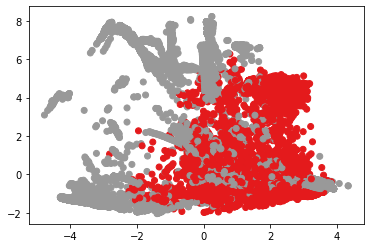

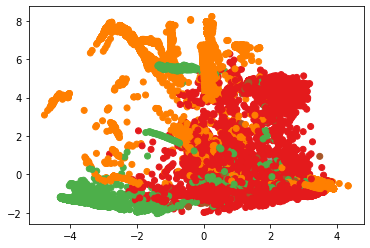

24.50026535987854


In [70]:
t0 = time()
viz_train_data = np.array(pca_train_df.rdd.map(lambda row: [*row['pca_features'], row['labels2_index'], row['labels5_index']]).collect())
plt.figure()
plt.scatter(x=viz_train_data[:,0], y=viz_train_data[:,1], c=viz_train_data[:,2], cmap="Set1")
plt.figure()
plt.scatter(x=viz_train_data[:,0], y=viz_train_data[:,1], c=viz_train_data[:,3], cmap="Set1")
plt.show()
print(time() - t0)

In [71]:
kmeans_prob_col = 'kmeans_rf_prob'
kmeans_pred_col = 'kmeans_rf_pred'

prob_cols.append(kmeans_prob_col)
pred_cols.append(kmeans_pred_col)

In [72]:
# KMeans clustrering
from pyspark.ml.clustering import KMeans

t0 = time()
kmeans_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features", 
                             names=list(set(selectFeaturesByAR(ar_dict, 0.1)).intersection(numeric_cols)))

kmeans = KMeans(k=8, initSteps=25, maxIter=100, featuresCol="features", predictionCol="cluster", seed=seed)

kmeans_pipeline = Pipeline(stages=[kmeans_slicer, kmeans])

kmeans_model = kmeans_pipeline.fit(scaled_train_df)

kmeans_train_df = kmeans_model.transform(scaled_train_df).cache()
kmeans_cv_df = kmeans_model.transform(scaled_cv_df).cache()
kmeans_test_df = kmeans_model.transform(scaled_test_df).cache()

print(time() - t0)

16.834809064865112


In [73]:
# Function for describing the contents of the clusters 
def getClusterCrosstab(df, clusterCol='cluster'):
    return (df.crosstab(clusterCol, 'labels2')
              .withColumn('count', col('attack') + col('normal'))
              .withColumn(clusterCol + '_labels2', col(clusterCol + '_labels2').cast('int'))
              .sort(col(clusterCol +'_labels2').asc()))

In [74]:
kmeans_crosstab = getClusterCrosstab(kmeans_train_df).cache()
kmeans_crosstab.show(n=30)

+---------------+------+------+-----+
|cluster_labels2|attack|normal|count|
+---------------+------+------+-----+
|              0|  3582|  4273| 7855|
|              1|   224|   398|  622|
|              2| 27727|    99|27826|
|              3|  5489| 46749|52238|
|              4|  2172|   178| 2350|
|              5|     2|    11|   13|
|              6|  7627|  2265| 9892|
|              7|     2|    42|   44|
+---------------+------+------+-----+



In [75]:
# Function for splitting clusters
def splitClusters(crosstab):
    exp = ((col('count') > 25) & (col('attack') > 0) & (col('normal') > 0))

    cluster_rf = (crosstab
        .filter(exp).rdd
        .map(lambda row: (int(row['cluster_labels2']), [row['count'], row['attack']/row['count']]))
        .collectAsMap())

    cluster_mapping = (crosstab
        .filter(~exp).rdd
        .map(lambda row: (int(row['cluster_labels2']), 1.0 if (row['count'] <= 25) | (row['normal'] == 0) else 0.0))
        .collectAsMap())
    
    return cluster_rf, cluster_mapping

kmeans_cluster_rf, kmeans_cluster_mapping = splitClusters(kmeans_crosstab)

print(len(kmeans_cluster_rf), len(kmeans_cluster_mapping))
print(kmeans_cluster_mapping)
kmeans_cluster_rf

7 1
{5: 1.0}


{0: [7855, 0.4560152768936983],
 1: [622, 0.36012861736334406],
 2: [27826, 0.9964421763818012],
 3: [52238, 0.10507676404150236],
 4: [2350, 0.9242553191489362],
 6: [9892, 0.7710270926000808],
 7: [44, 0.045454545454545456]}

In [76]:
from pyspark.ml.classification import RandomForestClassifier

# This function returns Random Forest models for provided clusters
def getClusterModels(df, cluster_rf):
    cluster_models = {}

    labels_col = 'labels2_cl_index'
    labels2_indexer.setOutputCol(labels_col)

    rf_slicer = VectorSlicer(inputCol="indexed_features", outputCol="rf_features", 
                             names=selectFeaturesByAR(ar_dict, 0.05))

    for cluster in cluster_rf.keys():
        t1 = time()
        rf_classifier = RandomForestClassifier(labelCol=labels_col, featuresCol='rf_features', seed=seed,
                                               numTrees=500, maxDepth=20, featureSubsetStrategy="sqrt")
        
        rf_pipeline = Pipeline(stages=[labels2_indexer, rf_slicer, rf_classifier])
        cluster_models[cluster] = rf_pipeline.fit(df.filter(col('cluster') == cluster))
        print("Finished %g cluster in %g ms" % (cluster, time() - t1))
        
    return cluster_models

In [77]:
# This utility function helps to get predictions/probabilities for the new data and return them into one dataframe
def getProbabilities(df, probCol, cluster_mapping, cluster_models):
    pred_df = (sqlContext.createDataFrame([], StructType([
                    StructField('id', LongType(), False),
                    StructField(probCol, DoubleType(), False)])))
    
    udf_map = udf(lambda cluster: cluster_mapping[cluster], DoubleType())
    pred_df = pred_df.union(df.filter(col('cluster').isin(list(cluster_mapping.keys())))
                            .withColumn(probCol, udf_map(col('cluster')))
                            .select('id', probCol))

                                       
    for k in cluster_models.keys():
        maj_label = cluster_models[k].stages[0].labels[0]
        udf_remap_prob = udf(lambda row: float(row[0]) if (maj_label == 'attack') else float(row[1]), DoubleType())

        pred_df = pred_df.union(cluster_models[k]
                         .transform(df.filter(col('cluster') == k))
                         .withColumn(probCol, udf_remap_prob(col('probability')))
                         .select('id', probCol))

    return pred_df

In [78]:
# Training Random Forest classifiers for each of the clusters
t0 = time()
kmeans_cluster_models = getClusterModels(kmeans_train_df, kmeans_cluster_rf)
print(time() - t0)

Finished 0 cluster in 26.4269 ms
Finished 1 cluster in 4.37929 ms
Finished 2 cluster in 27.1544 ms
Finished 3 cluster in 273.094 ms
Finished 4 cluster in 6.85765 ms
Finished 6 cluster in 29.147 ms
Finished 7 cluster in 1.80218 ms
368.8691518306732


In [79]:
# Getting probabilities for CV data
t0 = time()
res_cv_df = (res_cv_df.drop(kmeans_prob_col)
             .join(getProbabilities(kmeans_cv_df, kmeans_prob_col, kmeans_cluster_mapping, kmeans_cluster_models), 'id')
             .cache())

print(res_cv_df.count())
print(time() - t0)

25133
110.26721835136414


In [80]:
# Getting probabilities for Test data
t0 = time()
res_test_df = (res_test_df.drop(kmeans_prob_col)
               .join(getProbabilities(kmeans_test_df, kmeans_prob_col, kmeans_cluster_mapping, kmeans_cluster_models), 'id')
               .cache())

print(res_test_df.count())
print(time() - t0)

22544
127.78225755691528


In [84]:
printReport(res_cv_df, kmeans_prob_col, e=0.5, labels=labels2)

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:60285)
Traceback (most recent call last):
  File "C:\Users\mkahs\Anaconda3\envs\tf-gpu\lib\site-packages\py4j\java_gateway.py", line 1145, in send_command
    self.socket.sendall(command.encode("utf-8"))
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\mkahs\Anaconda3\envs\tf-gpu\lib\site-packages\py4j\java_gateway.py", line 985, in send_command
    response = connection.send_command(command)
  File "C:\Users\mkahs\Anaconda3\envs\tf-gpu\lib\site-packages\py4j\java_gateway.py", line 1149, in send_command
    "Error while sending", e, proto.ERROR_ON_SEND)
py4j.protocol.Py4JNetworkError: Error while sending

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Us

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:60285)

In [ ]:
printReport(res_test_df, kmeans_prob_col, e=0.01, labels=labels22)